Unsupervised Learning

In [320]:
import pandas as pd
import numpy as np

# Завантаження даних
train_data = pd.read_csv('train.csv', index_col=0)


Первинний аналіз даних

In [321]:
print(train_data.head())
print(train_data.info())
print(train_data.describe())

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S

Очистка даних

In [322]:
# виключення даних що не мають значення для даної задачі
train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Заповнення відсутніх значень медіаною для числових змінних або заповнення відсутніх значень для категоріальних змінних
for column in train_data.columns:
    if train_data[column].dtype == 'object':
        train_data.fillna({column:train_data[column].mode()[0]}, inplace=True)
    else:
        train_data.fillna({column:train_data[column].median()}, inplace=True)


Кодування категоріальних змінних методом one-hot encoding, який перетворює кожну категорію на новий стовпець і присвоює значення 1 або 0 (1 стоїть, якщо категорія присутня, а 0 — якщо ні). Цей метод вирішує проблему введення хибного числового порядку категорій, але збільшує кількість стовпців у датасеті

In [323]:
# Використання one-hot encoding
train_data = pd.get_dummies(train_data, columns=train_data.select_dtypes(exclude=[np.number]).columns)

Нормалізація даних (щоб змінні мали однаковий масштаб)

In [324]:
from sklearn.preprocessing import StandardScaler

X = train_data.drop(['Survived'], axis=1)  # Видаляємо цільову змінну
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Кластеризація

In [325]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0)
clusters = kmeans.fit(X_scaled)

# мітки кластера
train_data['cluster'] = kmeans.labels_ = kmeans.labels_

# Обчислюємо відсоток виживання для кожного кластера
survival_rates = train_data.groupby('cluster')['Survived'].mean()
print(survival_rates)

cluster
0    0.155116
1    0.763636
2    0.446154
3    0.102041
4    0.857143
5    0.389610
6    0.252252
Name: Survived, dtype: float64


Візуалізація результатів<br/>
Використаємо техніку зниження розмірності (до 2D) PCA - Зменшення лінійної розмірності за допомогою декомпозиції за одиничними значеннями для проектування їх у нижчий розмірний простір. Вхідні дані центруються, але не масштабуються для кожної функції перед застосуванням ДОЗ

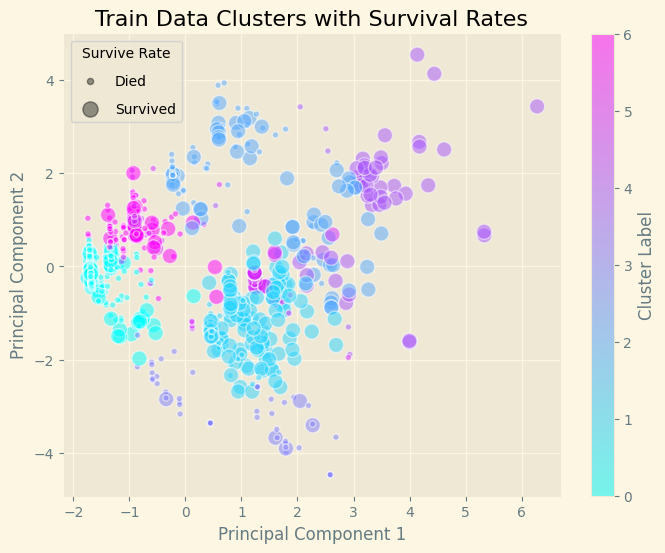

In [326]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_data['cluster'], cmap='cool', s=100*(0.2 + train_data['Survived']), alpha=0.5, edgecolor='w')

# Adding a color bar to understand which color represents which cluster
plt.colorbar(scatter, label='Cluster Label')
# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Train Data Clusters with Survival Rates')

# Adding a legend for sizes
plt.scatter([], [], c='k', alpha=0.4, s=20,label=f'Died')
plt.scatter([], [], c='k', alpha=0.4, s=120,label=f'Survived')

plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Survive Rate')

plt.show()


З попереднього графіку та обчислень видно, що у кластерах 4, 6, 2 найбільша сатистика виживання  

Повторимо попередні дії і для тестових даних але вже з визначиними параметрами кластерізації. Ткаож ми припускаємо, що шанси на виживання, які були обраховані для кожного кластера в тренувальних даних, залишаються схожими і для нових даних, які приходять у ці кластери. Це грунтується на припущенні, що кластеризація відобразила деяку внутрішню структуру даних, яка відповідає факторам, впливаючим на виживання.

cluster
0    0.155116
1    0.763636
2    0.446154
3    0.102041
4    0.857143
5    0.389610
6    0.252252
Name: Survived, dtype: float64


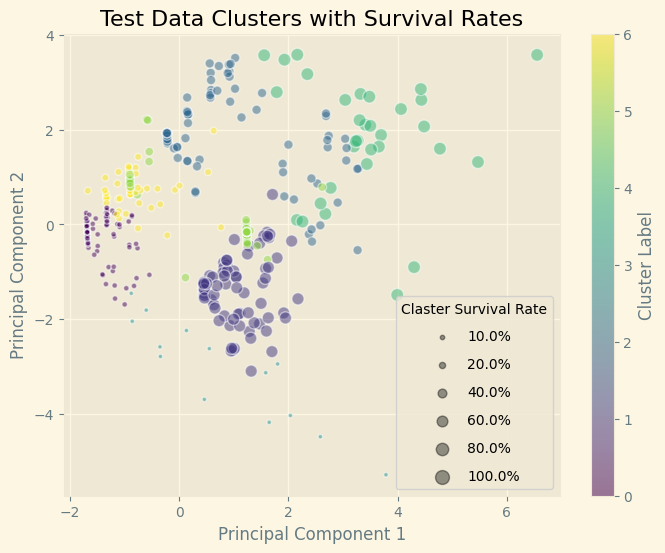

In [329]:
test_data = pd.read_csv('test.csv',index_col=0)
test_data.head()
# виключення даних що не мають значення для даної задачі
test_data.drop(['Cabin','Name', 'Ticket'], axis=1, inplace=True)

# Заповнення відсутніх значень медіаною для числових змінних або заповнення відсутніх значень для категоріальних змінних
for column in test_data.columns:
    if test_data[column].dtype == 'object':
        test_data.fillna({column:test_data[column].mode()[0]}, inplace=True)
    else:
        test_data.fillna({column:test_data[column].median()}, inplace=True)

# Кодування категоріальних змінних
test_data = pd.get_dummies(test_data)

# Нормалізація даних
test_data_scaled = scaler.transform(test_data)

test_labels = kmeans.predict(test_data_scaled)
test_data['cluster'] = test_labels

test_data['predicted_survival'] = test_data['cluster'].map(survival_rates)
# Обчислюємо відсоток виживання для кожного кластера
survival_rates = train_data.groupby('cluster')['Survived'].mean()
print(survival_rates)

#Візуалізація результатів для тестових даних
X_test_pca = pca.transform(test_data_scaled)  # вже існуючий PCA

plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_data['cluster'], cmap='viridis', s=100 * test_data['predicted_survival'], alpha=0.5, edgecolor='w')
# Adding a color bar to understand which color represents which cluster
plt.colorbar(scatter, label='Cluster Label')
# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Data Clusters with Survival Rates')

# Adding a legend for sizes
for size in [0.1,0.2, 0.4, 0.6, 0.8, 1.0]:
    plt.scatter([], [], c='k', alpha=0.4, s=100*size,
                label=f'{size*100}%')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Claster Survival Rate')


plt.show()


Коли ми кластеризуємо дані, ми робимо це без врахування міток (тобто без врахування того, хто вижив або ні у випадку Titanic). Однак, аналізуючи тренувальні дані, ми можемо з'ясувати середні шанси на виживання для кожного кластера. Це дає нам уявлення про те, які кластери могли б складатися з більш високого відсотка виживших (тобто які характеристики впливають з більш високим відсотком на виживання) і навпаки. 